# Pennsylvania Recom Experiment

## Preliminary Steps

Import some packages.

In [1]:
import geopandas as gpd

import random

import matplotlib.pyplot as plt
from functools import partial
import networkx as nx

from gerrychain import MarkovChain
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept
from gerrychain.updaters import Election, Tally, cut_edges
from gerrychain.partition import Partition
from gerrychain.proposals import recom
from gerrychain.metrics import mean_median, efficiency_gap

import csv
import os
from functools import partial
import json

import matplotlib.pyplot as plt

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.tree import recursive_tree_part

Define functions to create district adjacency graphs.

In [2]:
def district_pairs(part):
    pairs = []
    for x, y in part['cut_edges']:
        pairs.append((part.assignment[x],part.assignment[y]))
    return set(pairs)

def adjacency_graph_cut_edges(part):
    edges = district_pairs(part)
    adjacency_graph = nx.Graph()
    adjacency_graph.add_nodes_from(list({x for (x,y) in edges}))
    adjacency_graph.add_edges_from(list(edges))
    return adjacency_graph

Import some data.

In [3]:
newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")


graph_path = "./Data/PA_VTDALL.json"  # "./Data/PA_BPOP_FINAL/VTD_FINAL.shp"
plot_path = "./Data/VTD_FINAL.shp"

In [4]:
df = gpd.read_file(plot_path)


unique_label = "GEOID10"
pop_col = "TOT_POP"
district_col = "2011_PLA_1"
county_col = "COUNTYFP10"

num_elections = 3


election_names = [
    "PRES12",
    "PRES16",
    "SENW101216",
]
election_columns = [
    ["PRES12D", "PRES12R"],
    ["T16PRESD", "T16PRESR"],
    ["W101216D", "W101216R"],
]


graph = Graph.from_json(graph_path)

Define updaters.

In [5]:
updaters1 = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

updaters1.update(election_updaters)

We will look at some 'premade' partitions. In particular, `partition_2011` is the real districting plan from 2011.

In [6]:
partition_2011 = Partition(graph, "2011_PLA_1", updaters1)
partition_GOV = Partition(graph, "GOV", updaters1)
partition_TS = Partition(graph, "TS", updaters1)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters1)
partition_CPCT = Partition(graph, "538CPCT__1", updaters1)
partition_DEM = Partition(graph, "538DEM_PL", updaters1)
partition_GOP = Partition(graph, "538GOP_PL", updaters1)
partition_8th = Partition(graph, "8THGRADE_1", updaters1)

## Running a Markov Chain to Create Random Districting Plans

In [7]:
newdir = "./Outputs/"
os.makedirs(os.path.dirname(newdir + "init.txt"), exist_ok=True)
with open(newdir + "init.txt", "w") as f:
    f.write("Created Folder")


graph_path = "./Data/PA_VTDALL.json"  # "./Data/PA_BPOP_FINAL/VTD_FINAL.shp"
plot_path = "./Data/VTD_FINAL.shp"


df = gpd.read_file(plot_path)

In [8]:
def num_splits(partition):
    df["current"] = df[unique_label].map(dict(partition.assignment))
    splits = sum(df.groupby("COUNTYFP10")["current"].nunique() > 1)
    return splits


unique_label = "GEOID10"
pop_col = "TOT_POP"
district_col = "2011_PLA_1"
county_col = "COUNTYFP10"

num_elections = 14


election_names = [
    "BPOP",
    "ATG12",
    "GOV14",
    "GOV10",
    "PRES12",
    "SEN10",
    "ATG16",
    "PRES16",
    "SEN16",
    "SEN12",
    "SENW1012",
    "SENW1016",
    "SENW101216",
    "SENW1216",
]
election_columns = [
    ["BPOP", "nBPOP"],
    ["ATG12D", "ATG12R"],
    ["F2014GOVD", "F2014GOVR"],
    ["GOV10D", "GOV10R"],
    ["PRES12D", "PRES12R"],
    ["SEN10D", "SEN10R"],
    ["T16ATGD", "T16ATGR"],
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["USS12D", "USS12R"],
    ["W1012D", "W1012R"],
    ["W1016D", "W1016R"],
    ["W101216D", "W101216R"],
    ["W1216D", "W1216R"],
]

In [9]:
graph = Graph.from_json(graph_path)


updaters2 = {
    "population": updaters.Tally("TOT_POP", alias="population"),
    "cut_edges": cut_edges,
}

elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}

updaters2.update(election_updaters)


initial_partition = Partition(graph, "2011_PLA_1", updaters2)

In [10]:
ideal_population = sum(initial_partition["population"].values()) / len(
    initial_partition
)

print(ideal_population)

704718.2777777778


In [11]:
proposal = partial(
    recom, pop_col="TOT_POP", pop_target=ideal_population, epsilon=0.02, node_repeats=2
)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

In [12]:
tot_steps = 5000

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.02),
        compactness_bound,  # single_flip_contiguous#no_more_discontiguous
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=tot_steps,
)

In [16]:
# with open(newdir + "Start_Values.txt", "w") as f:
#     f.write("Values for Starting Plan: 2011 Enacted\n \n ")
#     f.write("Initial Cut: " + str(len(initial_partition["cut_edges"])))
#     f.write("\n")
#     f.write("\n")
#     f.write("Initial County Splits: " + str(num_splits(initial_partition)))
#     f.write("\n")
#     f.write("\n")

#     for elect in range(num_elections):
#         f.write(
#             election_names[elect]
#             + "District Percentages"
#             + str(
#                 sorted(initial_partition[election_names[elect]].percents("Democratic"))
#             )
#         )
#         f.write("\n")
#         f.write("\n")

#         f.write(
#             election_names[elect]
#             + "Mean-Median :"
#             + str(mean_median(initial_partition[election_names[elect]]))
#         )

#         f.write("\n")
#         f.write("\n")

#         f.write(
#             election_names[elect]
#             + "Efficiency Gap :"
#             + str(efficiency_gap(initial_partition[election_names[elect]]))
#         )

#         f.write("\n")
#         f.write("\n")

#         f.write(
#             election_names[elect]
#             + "How Many Seats :"
#             + str(initial_partition[election_names[elect]].wins("Democratic"))
#         )

#         f.write("\n")
#         f.write("\n")


# pop_vec = []
# cut_vec = []
# votes = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
# mms = []
# egs = []
# hmss = []

# splits = []

# t = 0
# for part in chain:
#     splits.append(num_splits(part))

#     pop_vec.append(sorted(list(part["population"].values())))
#     cut_vec.append(len(part["cut_edges"]))
#     mms.append([])
#     egs.append([])
#     hmss.append([])

#     for elect in range(num_elections):
#         votes[elect].append(sorted(part[election_names[elect]].percents("Democratic")))
#         mms[-1].append(mean_median(part[election_names[elect]]))
#         egs[-1].append(efficiency_gap(part[election_names[elect]]))
#         hmss[-1].append(part[election_names[elect]].wins("Democratic"))

#     t += 1
#     if t % 100 == 0:
#         print(t)
#         with open(newdir + "mms" + str(t) + ".csv", "w") as tf1:
#             writer = csv.writer(tf1, lineterminator="\n")
#             writer.writerows(mms)

#         with open(newdir + "egs" + str(t) + ".csv", "w") as tf1:
#             writer = csv.writer(tf1, lineterminator="\n")
#             writer.writerows(egs)

#         with open(newdir + "hmss" + str(t) + ".csv", "w") as tf1:
#             writer = csv.writer(tf1, lineterminator="\n")
#             writer.writerows(hmss)

#         with open(newdir + "pop" + str(t) + ".csv", "w") as tf1:
#             writer = csv.writer(tf1, lineterminator="\n")
#             writer.writerows(pop_vec)

#         with open(newdir + "cuts" + str(t) + ".csv", "w") as tf1:
#             writer = csv.writer(tf1, lineterminator="\n")
#             writer.writerows([cut_vec])

#         with open(newdir + "splits" + str(t) + ".csv", "w") as tf1:
#             writer = csv.writer(tf1, lineterminator="\n")
#             writer.writerows([splits])

#         with open(newdir + "assignment" + str(t) + ".json", "w") as jf1:
#             json.dump(dict(part.assignment), jf1)

#         for elect in range(num_elections):
#             with open(
#                 newdir + election_names[elect] + "_" + str(t) + ".csv", "w"
#             ) as tf1:
#                 writer = csv.writer(tf1, lineterminator="\n")
#                 writer.writerows(votes[elect])

#         #df["plot" + str(t)] = df["GEOID10"].map(dict(part.assignment))
#         #df.plot(column="plot" + str(t), cmap="tab20")
#         #plt.savefig(newdir + "plot" + str(t) + ".png")
#         #plt.close()

#         votes = [[], [], [], [], [], [], [], [], [], [], [], [], [], []]
#         mms = []
#         egs = []
#         hmss = []
#         pop_vec = []
#         cut_vec = []
#         splits = []

100
200
300
400
500


## Import Real Districting Plans

In [13]:
partition_2011 = Partition(graph, "2011_PLA_1", updaters1)
partition_GOV = Partition(graph, "GOV", updaters1)
partition_TS = Partition(graph, "TS", updaters1)
partition_REMEDIAL = Partition(graph, "REMEDIAL_P", updaters1)
partition_CPCT = Partition(graph, "538CPCT__1", updaters1)
partition_DEM = Partition(graph, "538DEM_PL", updaters1)
partition_GOP = Partition(graph, "538GOP_PL", updaters1)
partition_8th = Partition(graph, "8THGRADE_1", updaters1)

## Create Tree Districting Plans

In [14]:
tree_partitions = []

tree_plans = 20
n_base_plans = 8

for i in range(tree_plans):
    print('Finished tree plan', i)
    cddict = recursive_tree_part(graph, range(18), df["TOT_POP"].sum() / 18, "TOT_POP", .01, 1)
    tree_partitions.append(Partition(graph, cddict, updaters1))

Finished tree plan 0
Finished tree plan 1
Finished tree plan 2
Finished tree plan 3
Finished tree plan 4
Finished tree plan 5
Finished tree plan 6
Finished tree plan 7
Finished tree plan 8
Finished tree plan 9
Finished tree plan 10
Finished tree plan 11
Finished tree plan 12
Finished tree plan 13
Finished tree plan 14
Finished tree plan 15
Finished tree plan 16
Finished tree plan 17
Finished tree plan 18
Finished tree plan 19


## Put Everything Together

Now we append our Markov chain partitions to the partition list. This produces a list of `num_partitions` partitions, starting with real plans, moving to tree plans, finally including steps in the Markov chain.

In [15]:
recom_partitions = []
for i, step in enumerate(chain):
    recom_partitions.append(step)
    if i%250==0:
        print(i)

0
250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500
3750
4000
4250
4500
4750


Pick a subset of recom partitions to analyze.

In [17]:
recom_partitions_subset = []
for i in range(num_recom):
    if i%250 == 0:
        recom_partitions_subset.append(recom_partitions[i])

num_recom = len(recom_partitions_subset)
print(num_recom)

20


In [18]:
partition_list = [partition_2011, partition_GOV, partition_TS,
                  partition_REMEDIAL, partition_CPCT, partition_DEM,
                  partition_GOP, partition_8th]

In [19]:
labels = ['2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT', 'DEM', 'GOP', '8th'] + ["Recom" + str(k+1) for k in range(num_recom)]+["Tree" + str(k + 1) for k in range(tree_plans)];

In [20]:
print(labels)
print(len(labels))

['2011', 'GOV', 'TS', 'REMEDIAL', 'CPCT', 'DEM', 'GOP', '8th', 'Recom1', 'Recom2', 'Recom3', 'Recom4', 'Recom5', 'Recom6', 'Recom7', 'Recom8', 'Recom9', 'Recom10', 'Recom11', 'Recom12', 'Recom13', 'Recom14', 'Recom15', 'Recom16', 'Recom17', 'Recom18', 'Recom19', 'Recom20', 'Tree1', 'Tree2', 'Tree3', 'Tree4', 'Tree5', 'Tree6', 'Tree7', 'Tree8', 'Tree9', 'Tree10', 'Tree11', 'Tree12', 'Tree13', 'Tree14', 'Tree15', 'Tree16', 'Tree17', 'Tree18', 'Tree19', 'Tree20']
48


In [21]:
full_partition_list = partition_list + recom_partitions_subset + tree_partitions

In [22]:
num_partitions = len(full_partition_list)
print(num_partitions)

48


## Computing Adjacency Graphs and Barcodes

In [23]:
import gudhi as gd
import numpy as np

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):
/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

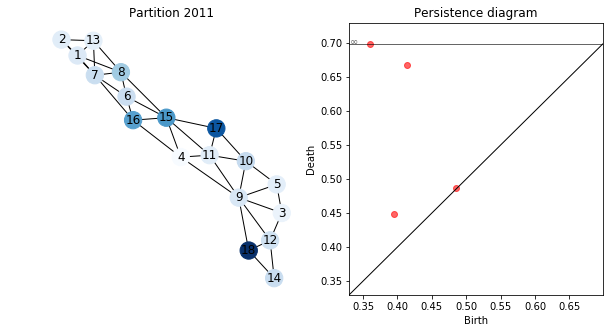

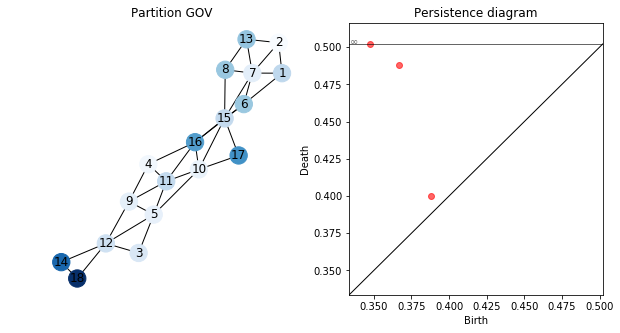

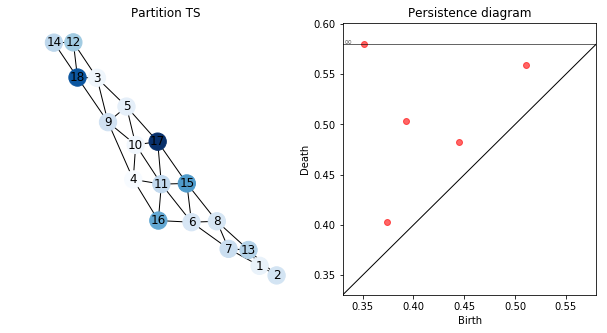

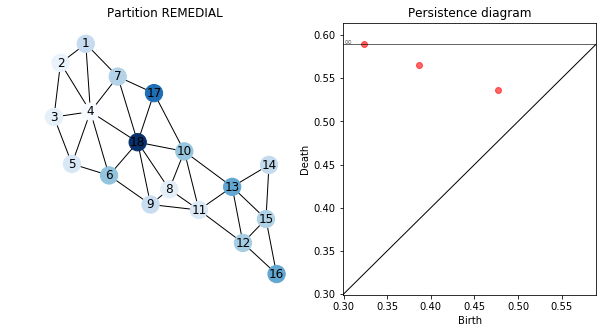

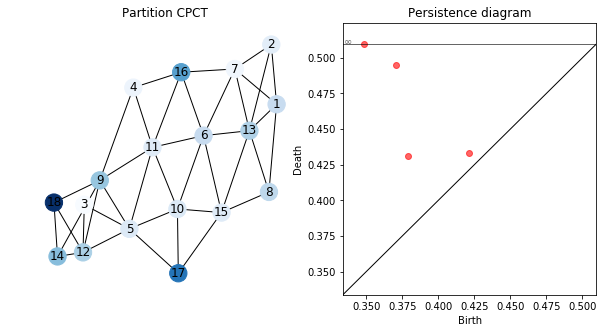

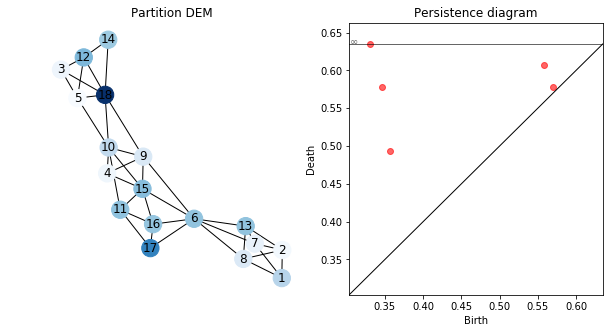

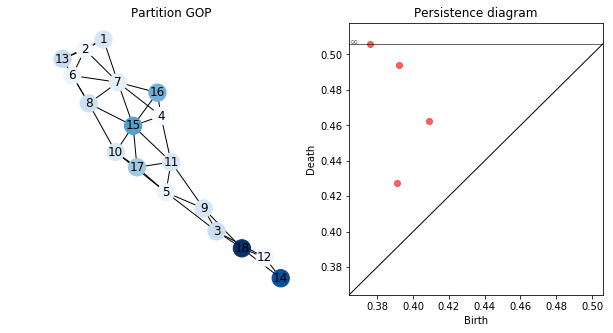

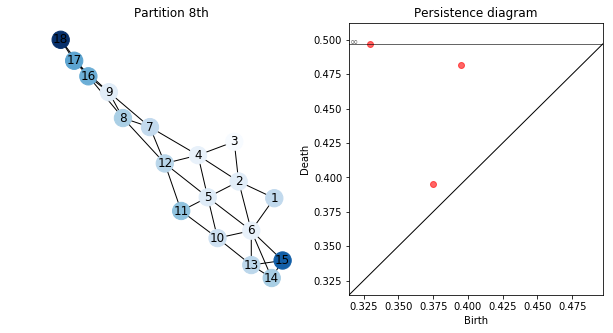

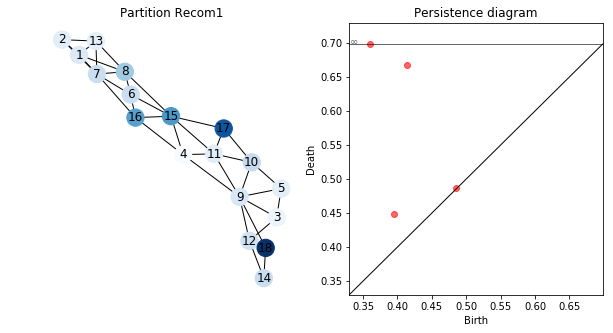

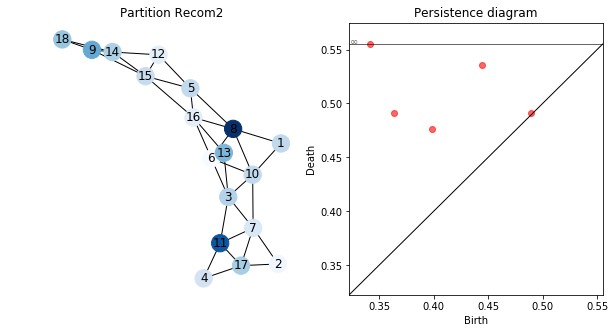

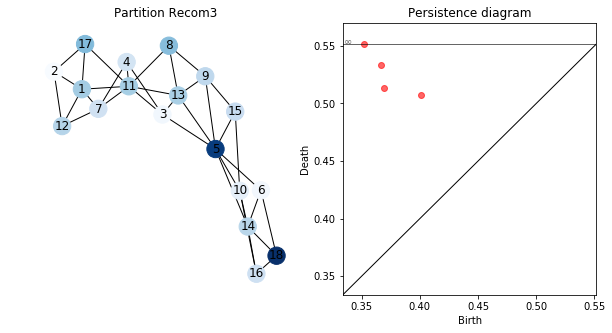

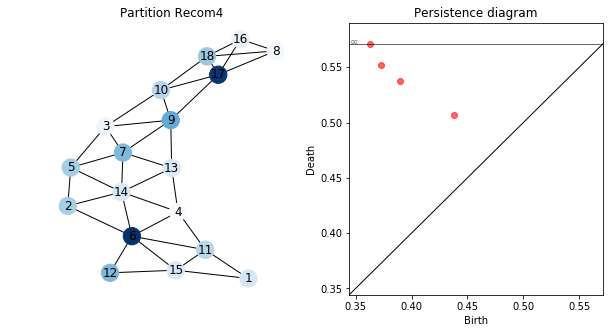

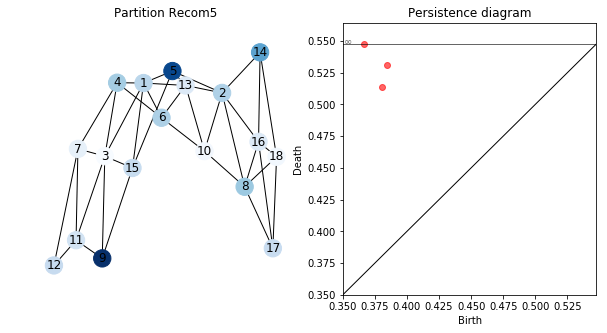

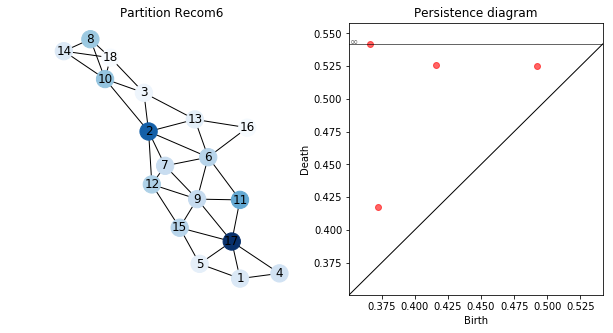

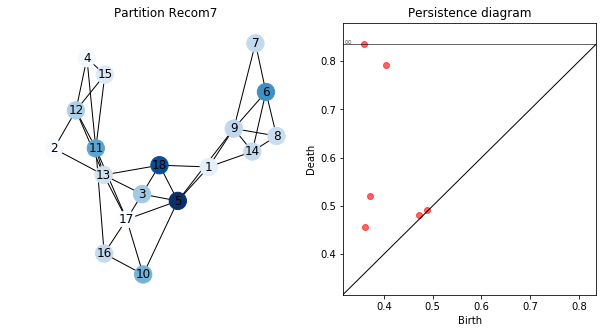

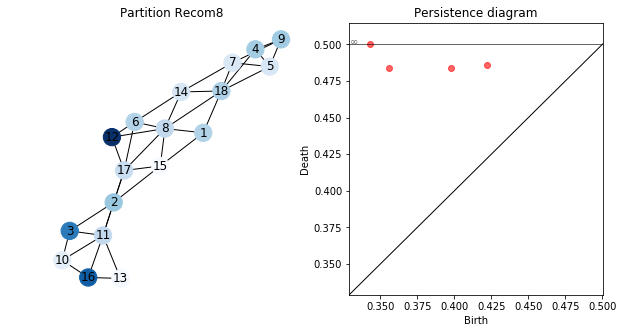

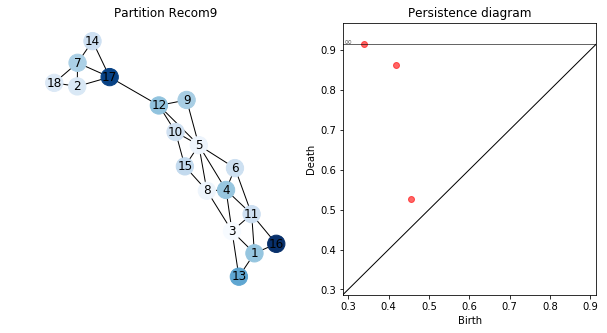

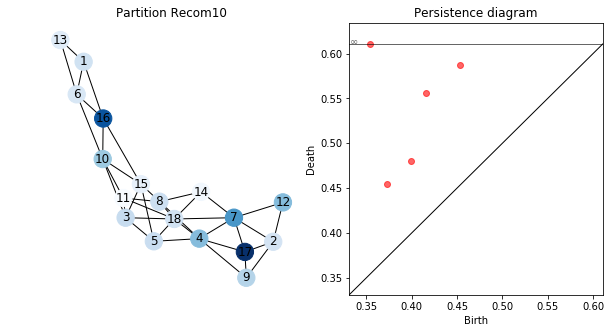

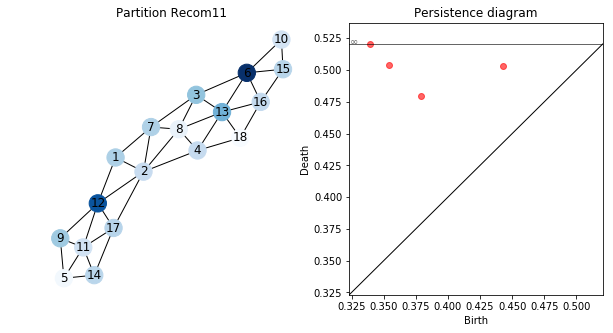

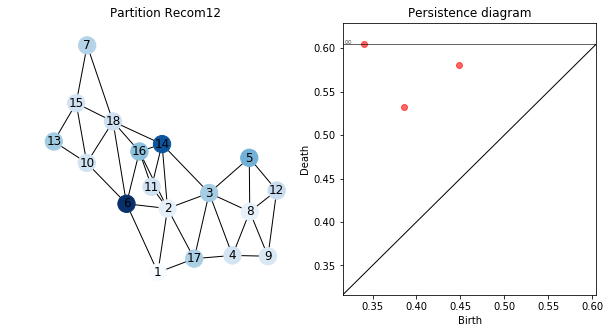

<Figure size 720x360 with 0 Axes>

In [24]:
for k in range(num_partitions):
    part = full_partition_list[k]

    adjacency_graph = adjacency_graph_cut_edges(part)

    spCpx = gd.SimplexTree()
    for edge in adjacency_graph.edges:
        spCpx.insert(list(edge))

    Democratic_voter_share = part['PRES12'].percents('Democratic')

    zero_skeleton = spCpx.get_skeleton(0)

    for j in range(len(zero_skeleton)):
        spCpx.assign_filtration(zero_skeleton[j][0], filtration=Democratic_voter_share[j])

    spCpx.make_filtration_non_decreasing()

    BarCodes = spCpx.persistence()

    fig = plt.figure(figsize = (10,5))

    ax = fig.add_subplot(1,2,1)
    nx.draw_networkx(adjacency_graph, node_color=Democratic_voter_share, cmap=plt.cm.Blues)
    plt.title('Partition '+labels[k])
    ax.axis('off')

    fig.add_subplot(1,2,2)
    gd.plot_persistence_diagram(BarCodes);

## Bottleneck Distances

In [25]:
partitions_spCpx = []

for k in range(num_partitions):
    part = full_partition_list[k]

    adjacency_graph = adjacency_graph_cut_edges(part)

    spCpx = gd.SimplexTree()
    for edge in adjacency_graph.edges:
        spCpx.insert(list(edge))
    
    Democratic_voter_share = part['PRES12'].percents('Democratic')
    
    zero_skeleton = spCpx.get_skeleton(0)

    for j in range(len(zero_skeleton)):
        spCpx.assign_filtration(zero_skeleton[j][0], filtration=Democratic_voter_share[j])

    spCpx.make_filtration_non_decreasing()

    partitions_spCpx.append(spCpx)

Now we can create a distance matrix containing the bottleneck distance between any pair of barcodes.

In [26]:
distMat = np.zeros((num_partitions,num_partitions))

for j in range(num_partitions):
    for k in range(num_partitions):
        spCpx0 = partitions_spCpx[j]
        spCpx1 = partitions_spCpx[k]
        
        spCpx0.persistence()
        spCpx1.persistence()

        I0 = spCpx0.persistence_intervals_in_dimension(0)
        I1 = spCpx1.persistence_intervals_in_dimension(0)

        distMat[j,k] = gd.bottleneck_distance(I0,I1)
        
# Symmetrize to remove any numerical errors

In [32]:
distMat = np.maximum(distMat, distMat.T)

We view the distance matrix as an image.

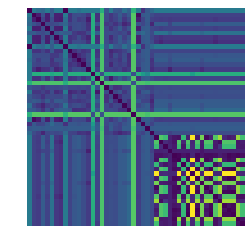

In [33]:
plt.imshow(distMat);
plt.axis('off');

To understand the shape of the 'space of districting plans', we can use Multi-Dimensional Scaling. This algorithm looks for the set of points in $\mathbb{R}^2$ (or $\mathbb{R}^3$) whose distance matrix is as close as possible to the distance matrix we just computed. For a more precise description, go here: https://en.wikipedia.org/wiki/Multidimensional_scaling

The result gives us a visualization of how similar the districting plans are.

In [34]:
colors = len(partition_list)*['r'] + len(recom_partitions_subset)*['g'] + len(tree_partitions)*['b']

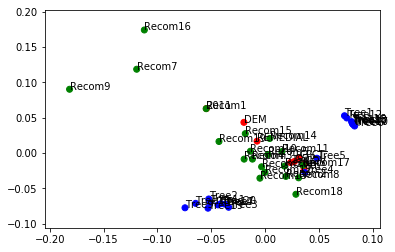

In [35]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMat)
coords = results.embedding_

z = coords[:,0]
y = coords[:,1]

fig, ax = plt.subplots()
ax.scatter(z, y, c = colors)

for i, txt in enumerate(labels):
    ax.annotate(txt, (z[i], y[i]))

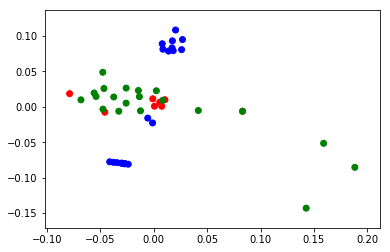

In [36]:
# Import a package containing the MDS algorithm and set options for the algorithm
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")

# Compute MDS and extract the coordinates of the points
results = mds.fit(distMat)
coords = results.embedding_

z = coords[:,0]
y = coords[:,1]

fig, ax = plt.subplots()
ax.scatter(z, y, c = colors)

We can also use MDS to project the data to 3D. It takes a little more work to make the plot. You can try running this a few times; MDS doesn't have a unique answer and the algorithm involves some randomness, so you will get something different every time you run it.

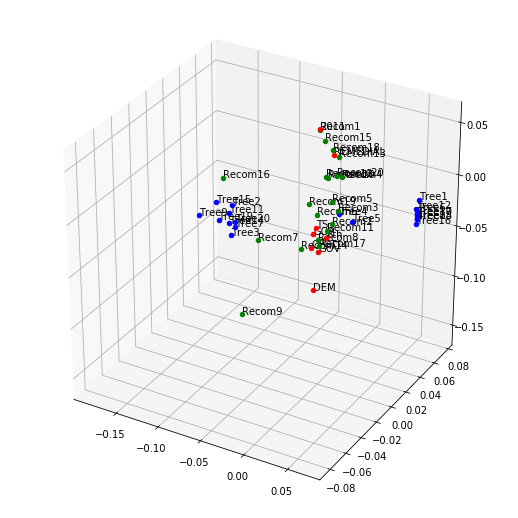

In [37]:
from mpl_toolkits.mplot3d import Axes3D

mds = manifold.MDS(n_components=3, dissimilarity="precomputed")
results = mds.fit(distMat)
coords = results.embedding_

fig = plt.figure(figsize = (7,7))
ax = Axes3D(fig)

for i, txt in enumerate(labels):
    ax.scatter(coords[i,0],coords[i,1],coords[i,2], c = colors[i]) 
    ax.text(coords[i,0],coords[i,1],coords[i,2],  '%s' % (txt), size=10, zorder=1) 


plt.show()

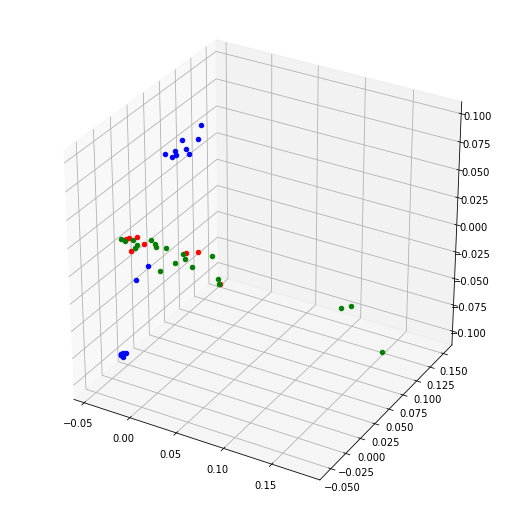

<Figure size 432x288 with 0 Axes>

In [46]:
from mpl_toolkits.mplot3d import Axes3D

mds = manifold.MDS(n_components=3, dissimilarity="precomputed")
results = mds.fit(distMat)
coords = results.embedding_

fig = plt.figure(figsize = (7,7))
ax = Axes3D(fig)

for i, txt in enumerate(labels):
    ax.scatter(coords[i,0],coords[i,1],coords[i,2], c = colors[i]) 


plt.show()
plt.savefig('PennsylvaniaRecomExperiment.png')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


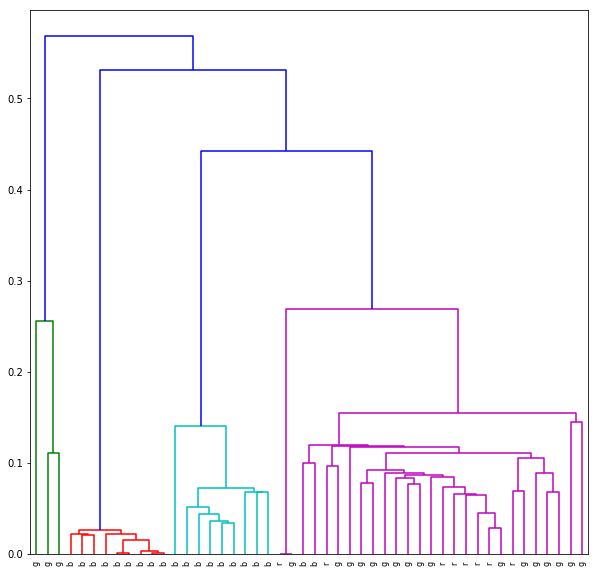

In [39]:
from scipy.cluster import hierarchy

linkage = hierarchy.linkage(distMat, 'single')


plt.figure(figsize = (10,10))
hierarchy.dendrogram(linkage, labels = colors);